In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

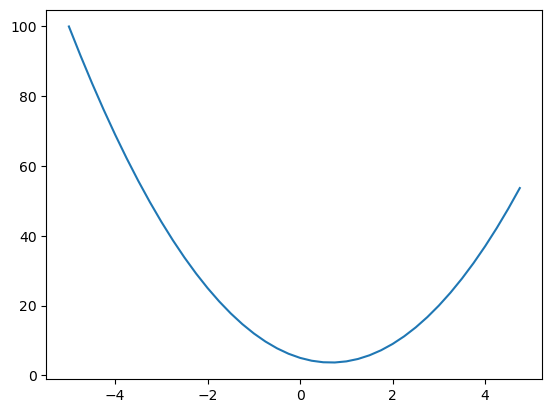

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
h = 0.001
x = -3.0
(f(x+h) - f(x))/h

-21.996999999998934

In [1]:
# lets get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [4]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c # this will be smaller than d1

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h) 

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [99]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        

    def __repr__(self):
        return f"Value(data={self.data}, op={self._op})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward # this assigns the instance "_backward" of the class to the reference of the _backward() func
        
        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward # this assigns the instance "_backward" of the class to the reference of the _backward() func
        
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward # this assigns the instance "_backward" of the class to the reference of the _backward() func
        
        return out
        

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
            
        out._backward = _backward
        return out
        

    def backward(self):
        self.grad = 1.0
        
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        
        for node in reversed(topo):
            node._backward()

In [78]:
a = Value(2.0)
b = Value(4.0)
a/b

Value(data=0.5, op=*)

In [79]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

Sigmoid function:

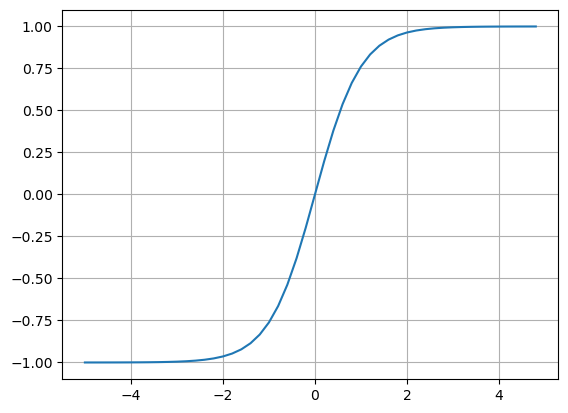

In [90]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [32]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.881373587019543, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'
o.backward()

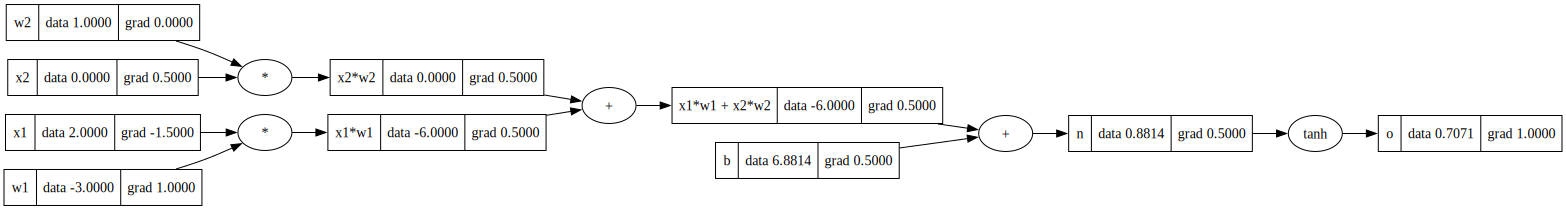

In [33]:
draw_dot(o)

break up tanh

In [100]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.881373587019543, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# ---
e = (2*n).exp()
o = (e - 1)/(e + 1)

o.label = 'o'
o.backward()

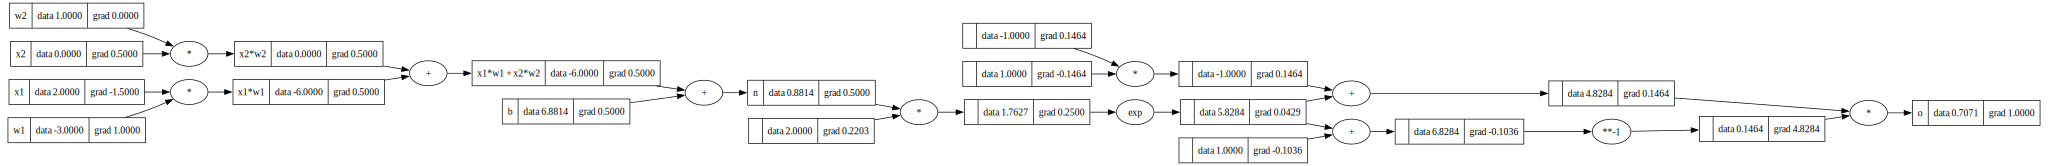

In [101]:
draw_dot(o)

How to do this but in Pytorch

In [102]:
import torch

In [103]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


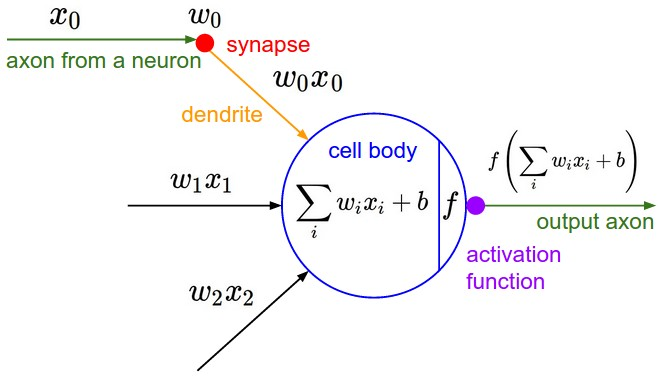

Now we make multiplayers with perceptron

In [118]:
import random
class Neuron:
  
  def __init__(self, nin): # nin is the number of inputs like how many input connections does this neuron have
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x): # x is a list of activation values for all the neurons in the prev layer
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh() # to squish it between 0 and 1
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    # nin is the number of inputs to each neurons
    # nout is the number of neurons for this layer or we can think of it as number of outputs for this layer
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    # evaluate the activation for each neuron in the layer
    # and return the list of all the activation values
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    # nin is the number of inputs (how many neurons are at the input)
    # nouts is num of neurons in each subsequent layers 
    sz = [nin] + nouts # [nin] is to cast nin into a list
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    # x here is list of activation of the input to the network
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [120]:
# How to use the Neuron class
# initialize the activation for 2 neurons
x = [2.0, 3.0, -1.0]

# create a neuron object
n = MLP(3, [4, 4, 1])

n(x) # what's the output

Value(data=-0.5443010222353997, op=tanh)

Let's train some simple example

In [121]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [127]:
ypreds = [n(x) for x in xs]
ypreds

[Value(data=-0.5443010222353997, op=tanh),
 Value(data=0.7362787702090717, op=tanh),
 Value(data=0.5665936108984941, op=tanh),
 Value(data=-0.42142001750134483, op=tanh)]

In [142]:
loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypreds)), Value(0))
loss

Value(data=9.874180023017534, op=+)

In [143]:
loss.backward()

In [144]:
n.layers[0].neurons[0].w[0]

Value(data=0.2716057805393004, op=)

In [145]:
n.parameters()

[Value(data=0.2716057805393004, op=),
 Value(data=0.15492121914596058, op=),
 Value(data=0.31905132663139035, op=),
 Value(data=-0.18609332029780745, op=),
 Value(data=0.7623015629262495, op=),
 Value(data=-0.8641535817230566, op=),
 Value(data=-0.33302102878415596, op=),
 Value(data=0.32785136393418957, op=),
 Value(data=-0.8171239534907626, op=),
 Value(data=0.9952596531050251, op=),
 Value(data=-0.5828207418176281, op=),
 Value(data=-0.028618034913275414, op=),
 Value(data=0.1449894450781377, op=),
 Value(data=-0.07924019491200673, op=),
 Value(data=0.9410253681939922, op=),
 Value(data=0.912174899613696, op=),
 Value(data=0.18476030386190923, op=),
 Value(data=0.8005483476597204, op=),
 Value(data=-0.15597299462621272, op=),
 Value(data=0.41900122047556976, op=),
 Value(data=-0.38029330863274713, op=),
 Value(data=0.22349927806646752, op=),
 Value(data=0.9996901470307515, op=),
 Value(data=-0.19268946665988573, op=),
 Value(data=-0.6199830616365563, op=),
 Value(data=0.938833494824

In [307]:
len(n.parameters())

41

In [453]:
for p in n.parameters():
    p.data -= 1 * p.grad

ypreds = [n(x) for x in xs]

loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypreds)), Value(0))

In [454]:
loss

Value(data=0.0019165245420781954, op=+)

In [455]:
for p in n.parameters():
    p.grad = 0.0 # we have to reset all the grad of the parameters because they all have new values now which will lead to different grad
loss.backward()


In [456]:
new_preds = [n(x) for x in xs]

In [457]:
new_preds

[Value(data=0.9845880460785662, op=tanh),
 Value(data=-0.9803696692904228, op=tanh),
 Value(data=-0.9731099569519196, op=tanh),
 Value(data=0.976113352694302, op=tanh)]